In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomLinkSplit

%config InlineBackend.figure_format='retina'

# Datasets

In [3]:
class PlainData(Data):
    """
    Custom Data class for use in PyG. Basically the same as the original Data class from PyG, but
    overrides the __inc__ method because otherwise the DataLoader was incrementing indices unnecessarily.
    Now it functions more like the original DataLoader from PyTorch itself.
    See here for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
    """
    def __inc__(self, key, value, *args, **kwargs):
        return 0

class MyDataset(Dataset):
    """
    Dataset object containing supervision/evaluation edges. This will be used by the DataLoader to load
    batches of edges to calculate loss or evaluation metrics on. Here, get(idx) will return ALL outgoing edges of the graph
    corresponding to user "idx". This is because when calculating metrics such as recall@k, we need all of the
    user's positive edges in the same batch.
    """
    def __init__(self, root, edge_index, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.unique_idxs = torch.unique(edge_index[0,:]).tolist()
        self.num_nodes = len(self.unique_idxs)
        super().__init__(root, transform, pre_transform)

    def len(self):
        return self.num_nodes

    def get(self, idx): # returns all outgoing edges associated with playlist idx
        edge_index = self.edge_index[:, self.edge_index[0,:] == idx]
        return PlainData(edge_index=edge_index)

In [4]:
class MovieLens:
    def __init__(self):
        # df = load_pandas_df('100k', ('UserId', 'ItemId', 'Rating'))
        df = pd.read_table('ml-100k/u.data', header=None, usecols=[0, 1, 2])
        df.columns = ('UserId', 'ItemId', 'Rating')
        df = df[df['Rating'] >= 4]
        encoder = LabelEncoder()
        df['UserId'] = encoder.fit_transform(df['UserId'])
        df['ItemId'] = encoder.fit_transform(df['ItemId'])
        df['ItemId'] += df['UserId'].max() + 1
        self.num_users = df['UserId'].nunique()
        self.df = df
        self._build_graph()
        self._train_test_split()

    def _build_edge_index(self):
        users = torch.tensor(self.df['UserId'].values, dtype=torch.long)
        items = torch.tensor(self.df['ItemId'].values, dtype=torch.long)
        source = torch.cat([users, items]).reshape(1, -1)
        target = torch.cat([items, users]).reshape(1, -1)
        edges = torch.cat([source, target], dim=0)
        return edges

    def _build_graph(self):
        edges = self._build_edge_index()
        self.num_nodes = len(edges.unique())
        self.edges = edges
        graph = Data(edge_index=edges, num_nodes=self.num_nodes)
        self.graph = graph

    def _train_test_split(self, val_ratio=0.15, test_ratio=0.15):
        splitter = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False,
                                   neg_sampling_ratio=0, num_val=val_ratio, num_test=test_ratio)
        train_split, val_split, test_split = splitter(self.graph)
        # Confirm that every node appears in every set above
        assert train_split.num_nodes == val_split.num_nodes and train_split.num_nodes == test_split.num_nodes

        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split

    def get_train(self):
        train_ev = MyDataset('movielens', edge_index=self.train_split.edge_label_index)
        train_mp = Data(edge_index=self.train_split.edge_index)
        return train_ev, train_mp

    def get_val(self):
        val_ev = MyDataset('movielens', edge_index=self.val_split.edge_label_index)
        val_mp = Data(edge_index=self.val_split.edge_index)
        return val_ev, val_mp

    def get_test(self):
        test_ev = MyDataset('movielens', edge_index=self.test_split.edge_label_index)
        test_mp = Data(edge_index=self.test_split.edge_index)
        return test_ev, test_mp

In [ ]:
mov = MovieLens()

train_ev, train_mp = mov.get_train()
val_ev, val_mp = mov.get_val()
test_ev, test_mp = mov.get_test()

In [2]:
def recall_at_k(pred_items: np.array, true_items: np.array):
    assert pred_items.shape[0] == true_items.shape[0]
    recall_list = []
    for i_pred, i_true in zip(pred_items, true_items):
        try:
            hits = len(np.intersect1d(i_pred, i_true))
            recall = hits / len(i_true)
            recall_list.append(recall)
        except ZeroDivisionError:
            print(len(recall_list), i_true)
    return np.mean(recall_list)

def precision_at_k(pred_items: np.array, true_items: np.array):
    assert pred_items.shape[0] == true_items.shape[0]
    precision_list = []
    for i_pred, i_true in zip(pred_items, true_items):
        try:
            hits = len(np.intersect1d(i_pred, i_true))
            prec = hits / len(i_pred)
            precision_list.append(prec)
        except ZeroDivisionError:
            print(len(precision_list), i_true)
    return np.mean(precision_list)

# LightGCN

In [ ]:
from torch_geometric.nn import LightGCN

class CustomLightGCN(LightGCN):
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight, gain=1)
        for conv in self.convs:
            conv.reset_parameters()

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, train_ev, val_ev, batch_size=256):
        self.model = model
        self.opt = optimizer
        self.train_loader = DataLoader(train_ev, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ev, batch_size=batch_size, shuffle=False)
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_train_step = 0
        self.global_val_step = 0
        self.writer = SummaryWriter("./logs")

        # сохраняем состояние оптимизатора и модели
        # self.cache = self.cache_states()

    @staticmethod
    def sample_negative_edges(batch, data_mp, num_users, num_nodes):
        negs = []
        for i in batch.edge_index[0, :]:  # looping over users
            assert i < num_users     # just ensuring that i is a user
            rand_item = torch.randint(num_users, num_nodes, (1,))  # randomly sample an item
            negs.append(rand_item.item())
        edge_index_negs = torch.row_stack([batch.edge_index[0, :], torch.LongTensor(negs)])
        return Data(edge_index=edge_index_negs, y=torch.LongTensor([0] * len(negs)))


    def train(self, data_mp, k, num_users, num_nodes):
        model = self.model
        opt = self.opt
        items = torch.tensor(np.arange(num_users, num_nodes))
        recall_all = []

        model.train()
        for batch in self.train_loader:
            del batch.batch; del batch.ptr # delete unwanted attributes

            opt.zero_grad()
            negs = self.sample_negative_edges(batch, data_mp, num_users, num_nodes)  # sample negative edges
            data_mp, batch, negs = data_mp.to(self.device), batch.to(self.device), negs.to(self.device)

            pos_scores = model.forward(data_mp['edge_index'], batch['edge_index'])
            neg_scores = model.forward(data_mp['edge_index'], negs['edge_index'])

            batch_index = batch['edge_index']
            users = batch_index[0].unique()
            recoms = model.recommend(data_mp['edge_index'], users, items, k=k)

            recall_batch = []
            for u, rec in zip(users, recoms):
                true_items = batch_index[1, batch_index[0] == u].cpu()
                hits = len(np.intersect1d(rec.cpu(), true_items))
                recall = hits / len(true_items)
                recall_batch.append(recall)
                recall_all.append(recall)

            # loss = pos_scores.shape[0] * model.recommendation_loss(pos_scores, neg_scores)
            loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
            loss.backward()
            # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
            #     print(f'Gradient norm on this layer = {p.grad.data.norm(2).item()}')  # Посмотрим на норму градиентов
            opt.step()

            self.writer.add_scalar("Recall/train", np.mean(recall_batch), global_step=self.global_train_step)
            self.writer.add_scalar("Loss/train", loss.item(), global_step=self.global_train_step)
            self.global_train_step += 1

        print(f'Train avg recall = {np.mean(recall_all).round(4)}')
        print(f'Current loss = {loss.item()}')
        return loss.item()


    def test(self, data_mp, k, num_users, num_nodes, train_split=None):
        model = self.model
        items = torch.LongTensor(np.arange(num_users, num_nodes))

        model.eval()
        with torch.no_grad():
            data_mp = data_mp.to(self.device)

            recall_all = []
            for batch in self.val_loader:
                del batch.batch; del batch.ptr # delete unwanted attributes
                batch = batch['edge_index']
                batch = batch.to(self.device)
                users = batch[0].unique_consecutive()
                recoms = model.recommend(data_mp['edge_index'], users, items, k=k)

                # --- FAIR BUT LONG METHOD ---
                # for user in tqdm(users):
                    # seen_items = set(train_split[1, train_split[0] == user].tolist())
                    # unseen_items = torch.LongTensor(list(items.difference(seen_items)))
                    # rec = model.recommend(data_mp['edge_index'], user, torch.tensor(list(items)), k=k)
                    # true_items = batch[1, batch[0] == user].cpu()

                recall_batch = []
                for u, rec in zip(users, recoms):
                    true_items = batch[1, batch[0] == u].cpu()
                    hits = len(np.intersect1d(rec.cpu(), true_items))
                    recall = hits / len(true_items)
                    recall_batch.append(recall)
                    recall_all.append(recall)

                self.writer.add_scalar("Recall/valid", np.mean(recall_batch), global_step=self.global_val_step)
                self.global_val_step += 1

        print(f'Valid avg recall = {np.mean(recall_all).round(4)}')

In [2]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir logs/

Launching TensorBoard...

# twin-LGCN-U/E

In [7]:
from torch_geometric.nn import MessagePassing
# from torch_geometric import utils
from torch_geometric.utils import degree, negative_sampling

In [6]:
class SimpleProp(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, x, edge_index, size):
        return self.propagate(edge_index, x=x, size=size)

    def message(self, x_j):
        return x_j

In [564]:
class LGCN_U(torch.nn.Module):
    def __init__(self, n_users, emb_dim, normalize=False, **kwargs):
        super().__init__()
        self.m = n_users
        self.normalize = normalize
        self.U_0 = torch.nn.Embedding(self.m, emb_dim)
        self.layer_1 = SimpleProp(**kwargs)  # E_1 = R.T @ U
        self.layer_2 = SimpleProp(**kwargs)  # U_2 = R @ E_1
        self.layer_3 = SimpleProp(**kwargs)  # E_3 = R @ U_2

    def get_embeddings(self):
        # """
        # Return final fused embeddings of user and items: U, E.
        # TODO: add possibility to pass different aggregation function for fusing
        # embeddings from different layers/nets.
        # """
        # E = self.E_1 + self.E_3
        # U = self.U_0 + self.U_2
        # return U, E
        pass

    def forward(self, edge_index, n=None):
        """Propagate messages through the graph and return fused final embeddings of users ans items: U, E"""
        if n is None:
            n = edge_index[1].max().item() + 1
        m = self.m

        if self.normalize:
            inv_sqrt_user_degrees = degree(edge_index[0]).pow(-0.5)
            inv_sqrt_item_degrees = degree(edge_index[1]).pow(-0.5)
            # inv_norm = inv_sqrt_user_degrees * inv_sqrt_item_degrees
        else:
            inv_sqrt_item_degrees = 1
            inv_sqrt_user_degrees = 1

        E_1 = self.layer_1.forward(self.U_0.weight, edge_index=edge_index, size=(m, n)) * inv_sqrt_item_degrees.view(-1, 1)
        U_2 = self.layer_2.forward(E_1, edge_index[[1, 0], :], size=(n, m)) * inv_sqrt_user_degrees.view(-1, 1)
        E_3 = self.layer_3.forward(U_2, edge_index, size=(m, n)) * inv_sqrt_item_degrees.view(-1, 1)

        E = E_1 + E_3
        U = self.U_0.weight + U_2
        return U, E

    def predict(self, edges_index, new_edges_index=None, n_items=None):
        """
        Predict scores of given pairs of (user, item) with learned user's embeddings.
        Might be used in inductive mode if new_edges_index is passed.
        """
        # From paper:
        # "Let R𝐼 denote new user-item interaction graph such that new items (i.e. new columns) are also appended"
        if new_edges_index is not None:
            edges_index = torch.cat([edges_index, new_edges_index], dim=1)

        U, E = self.forward(edges_index, n_items)
        src = U[edges_index[0]]
        dst = E[edges_index[1]]
        return (src * dst).sum(dim=-1)

    def recommend_top_k(self):
        pass

In [187]:
# R = torch.randint(2, (3,4))
R

tensor([[1, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0]])

### Pipeline (sanity check)

In [246]:
pos_edges = torch.nonzero(R).T
pos_edges

tensor([[0, 0, 1, 2],
        [0, 1, 2, 0]])

In [247]:
neg_edges = utils.negative_sampling(pos_edges, num_nodes=(3, 4))
neg_edges

tensor([[0, 1, 2, 1],
        [2, 0, 2, 3]])

In [340]:
model = LGCN_U(n_users=3, emb_dim=3)
opt = torch.optim.Adam(model.parameters(), lr=3e-2)
metrics = []

0.24593006074428558


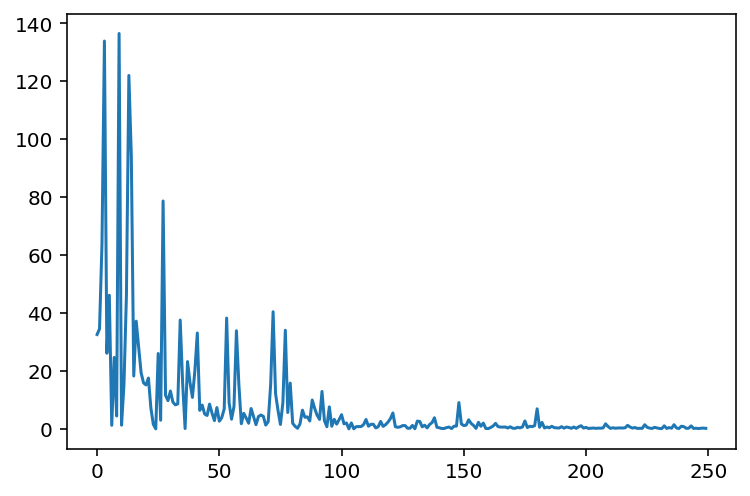

In [351]:
for i in range(10):
    opt.zero_grad()
    neg_edges = negative_sampling(pos_edges, num_nodes=(3, 4))
    pos_scores = model.predict(edges_index=pos_edges, n_items=4)
    neg_scores = model.predict(edges_index=neg_edges, n_items=4)

    loss = torch.mean(F.softplus(neg_scores - pos_scores))
    # print(loss.item())
    loss.backward()
    opt.step()
    metrics.append(loss.item())
print(metrics[-1])
plt.plot(metrics)
plt.show()

In [109]:
from sklearn.metrics.pairwise import cosine_similarity

In [344]:
R

tensor([[1, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0]])

In [352]:
cosine_similarity(model.forward(edge_index=pos_edges, n=4)[0].data.numpy())

array([[ 1.       , -0.7746767,  0.8162699],
       [-0.7746767,  1.       , -0.933676 ],
       [ 0.8162699, -0.933676 ,  0.9999999]], dtype=float32)

In [353]:
new_R = torch.Tensor([[1, 1, 0], [1, 1, 0], [0, 0, 1]])
new_R

tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])

In [354]:
new_edges = torch.nonzero(new_R).T
new_edges[1] += 4
new_edges

tensor([[0, 0, 1, 1, 2],
        [4, 5, 4, 5, 6]])

In [355]:
cosine_similarity(model.forward(torch.cat([pos_edges, new_edges], dim=1), 7)[0].detach().numpy())

array([[ 0.9999999 ,  0.09845882,  0.4470191 ],
       [ 0.09845882,  0.9999999 , -0.77198714],
       [ 0.4470191 , -0.77198714,  0.9999999 ]], dtype=float32)

In [356]:
_U, _E = model.forward(torch.cat([pos_edges, new_edges], dim=1), 7)

In [361]:
torch.cat([R, new_R], dim=1)

tensor([[1., 1., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1.]])

In [359]:
_U @ _E.T

tensor([[ 7.1969,  5.7982,  0.3556,  0.0000,  6.1539,  6.1539,  1.3987],
        [-1.1491,  0.3556,  2.2500,  0.0000,  2.6057,  2.6057, -1.5047],
        [ 3.0872,  1.3987, -1.5047,  0.0000, -0.1060, -0.1060,  1.6885]],
       grad_fn=<MmBackward0>)

### MovieLens

In [362]:
from sklearn.model_selection import train_test_split

In [389]:
class MovieLens:
    def __init__(self, path, nrows=None):
        df = pd.read_table(path, header=None, nrows=nrows)
        df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['user_id'] -= 1
        df['item_id'] -= 1
        # df = df[df['rating'] >= 4]
        df['rating'] = 1
        self.df = df

    def train_test_split(self, test_ratio=0.25, observed_ratio=0.5):
        df = self.df
        all_users = self.df['user_id'].unique()
        test_size = int(len(all_users) * test_ratio)

        # Формируем выборку пользователей для теста
        test_users = np.random.choice(a=all_users, size=test_size, replace=False)
        df_train = df[~df['user_id'].isin(test_users)]
        df_test = df[df['user_id'].isin(test_users)]
        df_test = df_test[df_test['item_id'].isin(df_train['item_id'].unique())]

        # Энкодим айдишники айтемов
        encoder = LabelEncoder()
        df_train['user_id'] = encoder.fit_transform(df_train['user_id'])
        df_train['item_id'] = encoder.fit_transform(df_train['item_id'])
        df_test['item_id'] = encoder.transform(df_test['item_id'])

        # Делим интеракции новых пользователей на виденные и будущие
        test_observed, test_future = train_test_split(df_test, test_size=1-observed_ratio, random_state=42)
        test_future = test_future[test_future['user_id'].isin(test_observed['user_id'].unique())]
        test_observed['user_id'] = encoder.fit_transform(test_observed['user_id'])
        test_future['user_id'] = encoder.transform(test_future['user_id'])

        self.train = df_train
        self.test_observed = test_observed
        self.test_future = test_future
        self.n_items = df_train['item_id'].nunique()

In [629]:
np.random.seed(42)
mov = MovieLens('ml-100k/u.data')
mov.df.shape

(100000, 4)

In [828]:
mov.train_test_split(test_ratio=0.3, observed_ratio=0.1)

/var/folders/p_/sddndwcs6m30b1tfj2cy1ys40000gn/T/ipykernel_21399/2064340322.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['user_id'] = encoder.fit_transform(df_train['user_id'])
/var/folders/p_/sddndwcs6m30b1tfj2cy1ys40000gn/T/ipykernel_21399/2064340322.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['item_id'] = encoder.fit_transform(df_train['item_id'])


In [829]:
mov.train.nunique()

user_id        661
item_id       1641
rating           1
timestamp    33933
dtype: int64

In [830]:
mov.test_observed.nunique()

user_id       272
item_id       931
rating          1
timestamp    2879
dtype: int64

In [831]:
mov.test_future.nunique()

user_id        272
item_id       1432
rating           1
timestamp    14507
dtype: int64

In [832]:
pos_edges = torch.LongTensor(mov.train[['item_id', 'user_id']].values.T)
pos_edges

tensor([[241, 301, 345,  ..., 203, 224, 202],
        [135, 127, 113,  ..., 509,   7,   6]])

In [833]:
len(pos_edges[0].unique()), len(pos_edges[1].unique())

(1641, 661)

In [969]:
model = LGCN_U(n_users=mov.train['item_id'].nunique(), emb_dim=32, normalize=True)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = []
# neg_edges = utils.negative_sampling(pos_edges, num_nodes=(model.m, 661))

In [970]:
# opt = torch.optim.Adam(model.parameters(), lr=1e-4)

2.3282928466796875
2.3282928466796875


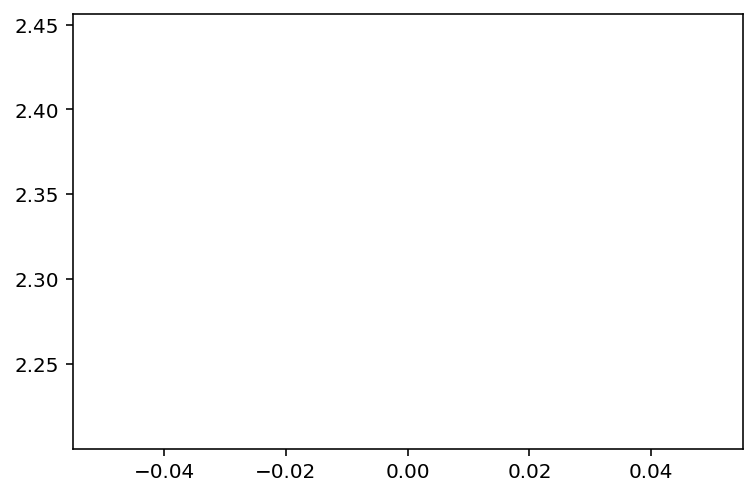

In [971]:
for i in range(1):
    opt.zero_grad()
    neg_edges = negative_sampling(pos_edges, num_nodes=(model.m, 661))
    pos_scores = model.predict(edges_index=pos_edges, n_items=661)
    neg_scores = model.predict(edges_index=neg_edges, n_items=661)

    loss = torch.mean(F.softplus(neg_scores - pos_scores))
    if i % 3 == 0:
        print(loss.item())
    loss.backward()
    opt.step()
    metrics.append(loss.item())

print(metrics[-1])
plt.plot(metrics[:])
plt.show()

In [954]:
test_observed_edges = torch.LongTensor(mov.test_observed[['item_id', 'user_id']].values.T)
test_observed_edges[1] += 661
test_observed_edges.min(dim=1).values, test_observed_edges.max(dim=1).values

(tensor([  0, 661]), tensor([1626,  932]))

In [972]:
with torch.no_grad():
    _U, _E = model.forward(torch.cat([pos_edges, test_observed_edges], dim=1), n=933)
_U.shape, _E.shape

(torch.Size([1641, 32]), torch.Size([933, 32]))

In [973]:
_U[1]

tensor([-0.0530, -2.4230,  1.6562,  1.6281, -4.6692,  1.5376,  5.6367, -1.8093,
         3.4892,  0.9444,  3.5041, -7.1271, 13.0829, -5.4995,  4.1230, -8.0553,
        10.0204, -5.4567, -8.4693, -1.3400,  9.0556, -1.0283,  3.8271,  1.8804,
         4.5268, -4.6778, -2.4056, 12.7897, -8.0574, -3.2403,  8.2759,  6.7889])

In [974]:
# new_scores = _E[661:] @ _U.T
# new_scores.shape

In [975]:
new_scores = _E @ _U.T
new_scores[test_observed_edges[1], test_observed_edges[0]] = -1e5  # exclude seen items
new_scores = new_scores[661:]
new_scores.shape

torch.Size([272, 1641])

In [976]:
recs = new_scores.topk(50, dim=1).indices.numpy()
recs

array([[ 49,  99, 180, ..., 150, 237, 653],
       [ 49, 180,  99, ..., 356, 745, 227],
       [ 49, 180,  99, ..., 179, 167, 150],
       ...,
       [ 49, 180,  99, ..., 150,  70, 653],
       [ 49, 180,  99, ..., 237, 653, 179],
       [180,  99, 257, ..., 181, 237, 134]])

In [977]:
y_true = mov.test_future.groupby('user_id')['item_id'].unique().values
print('===== LGCN-E =====')
print(f'Precsion = {precision_at_k(recs, y_true).round(5)}')
print(f'Recall = {recall_at_k(recs, y_true).round(5)}')

===== LGCN-E =====
Precsion = 0.38963
Recall = 0.23034


In [825]:
mov.test_observed.groupby('user_id')['item_id'].count().median()

31.5

In [824]:
mov.test_future.groupby('user_id')['item_id'].count().median()

33.0

In [671]:
50 / mov.train['user_id'].nunique()

0.07564296520423601

# LGCN-IDE

In [ ]:
class LGCN_IDE(object):
    def __init__(self, adj_mat):
        self.adj_mat = adj_mat

    def train(self, threshold: int):
        adj_mat = self.adj_mat[:threshold]
        rowsum = np.array(adj_mat.sum(axis=1))
        d_inv = np.power(rowsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat = sp.diags(d_inv)
        d_mat_i = d_mat
        norm_adj = d_mat.dot(adj_mat)

        colsum = np.array(adj_mat.sum(axis=0))
        d_inv = np.power(colsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat = sp.diags(d_inv)
        d_mat_u = d_mat
        d_mat_u_inv = sp.diags(1/d_inv)
        norm_adj = norm_adj.dot(d_mat)
        self.norm_adj = norm_adj.tocsr()

    def getUsersRating(self, batch_users, ds_name):
        norm_adj = self.norm_adj
        batch_test = np.array(norm_adj[batch_users,:].todense())
        U_1 = batch_test @ norm_adj.T @ norm_adj
        if(ds_name == 'gowalla'):
            U_2 = U_1 @ norm_adj.T @ norm_adj
            return U_2
        else:
            return U_1